In [81]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import random
from itertools import permutations

In [82]:
I = identity(2)
Z = sigmaz()
up1 = basis(2, 0)
down1 = basis(2, 1)

# Single-qubit Hamiltonians
H3 =  tensor(Z, Z, Z)
H2 =  tensor(Z, Z, I) + tensor(I, Z, Z) + tensor(Z,I,Z)

ID3 = tensor(I,I,I)
H = ID3 + H3 + ID3 + H2

eigenvalues, eigenstates = H.eigenstates()

basis_labels = ['|000⟩', '|001⟩', '|010⟩', '|011⟩', '|100⟩', '|101⟩', '|110⟩', '|111⟩']

print("Eigenvalues of the Hamiltonian:", eigenvalues)
for i, state in enumerate(eigenstates):
    if eigenvalues[i] == np.min(eigenvalues):
        min_eigenstate = state
        
        components = state.full().flatten()
        for i, component in enumerate(components):
            if np.abs(component) > 1e-6:
                spin_state = basis_labels[i]
                print(f"Spin state: {spin_state}")


Eigenvalues of the Hamiltonian: [0. 0. 0. 2. 2. 2. 4. 6.]
Spin state: |001⟩
Spin state: |010⟩
Spin state: |100⟩


In [410]:
def generate_random_solution(n_qubits):
    while True:
        solution = [random.randint(0, 1) for _ in range(n_qubits)]
        if sum(solution) <= (n_qubits / 2) and sum(solution) >= 1:  # Ensure the number of 1's is less than n_qubits / 2
            return solution

def generate_clause_from_solution(solution, qubit_indices):
    bits = [solution[i] for i in qubit_indices]
    
    if sum(bits) == 1:
        return tuple(sorted(qubit_indices))

    for perm in permutations(bits):
        if sum(perm) == 1:
            return tuple(sorted(qubit_indices))

    return ()

def generate_unique_ec3_instance(n_qubits, n_clauses, satisfying_assignment):
    clauses = set()
    
    while len(clauses) < n_clauses:
        qubit_indices = random.sample(range(n_qubits), 3)  # Select 3 qubits randomly
        clause = generate_clause_from_solution(satisfying_assignment, qubit_indices)
        
        if clause:
            clauses.add(clause)
    
    return sorted(list(clauses))

Unique satisfying bitstring: 0001
Generated EC3 clauses (n=4):
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)
Energy diff is:  0.35089091466433076


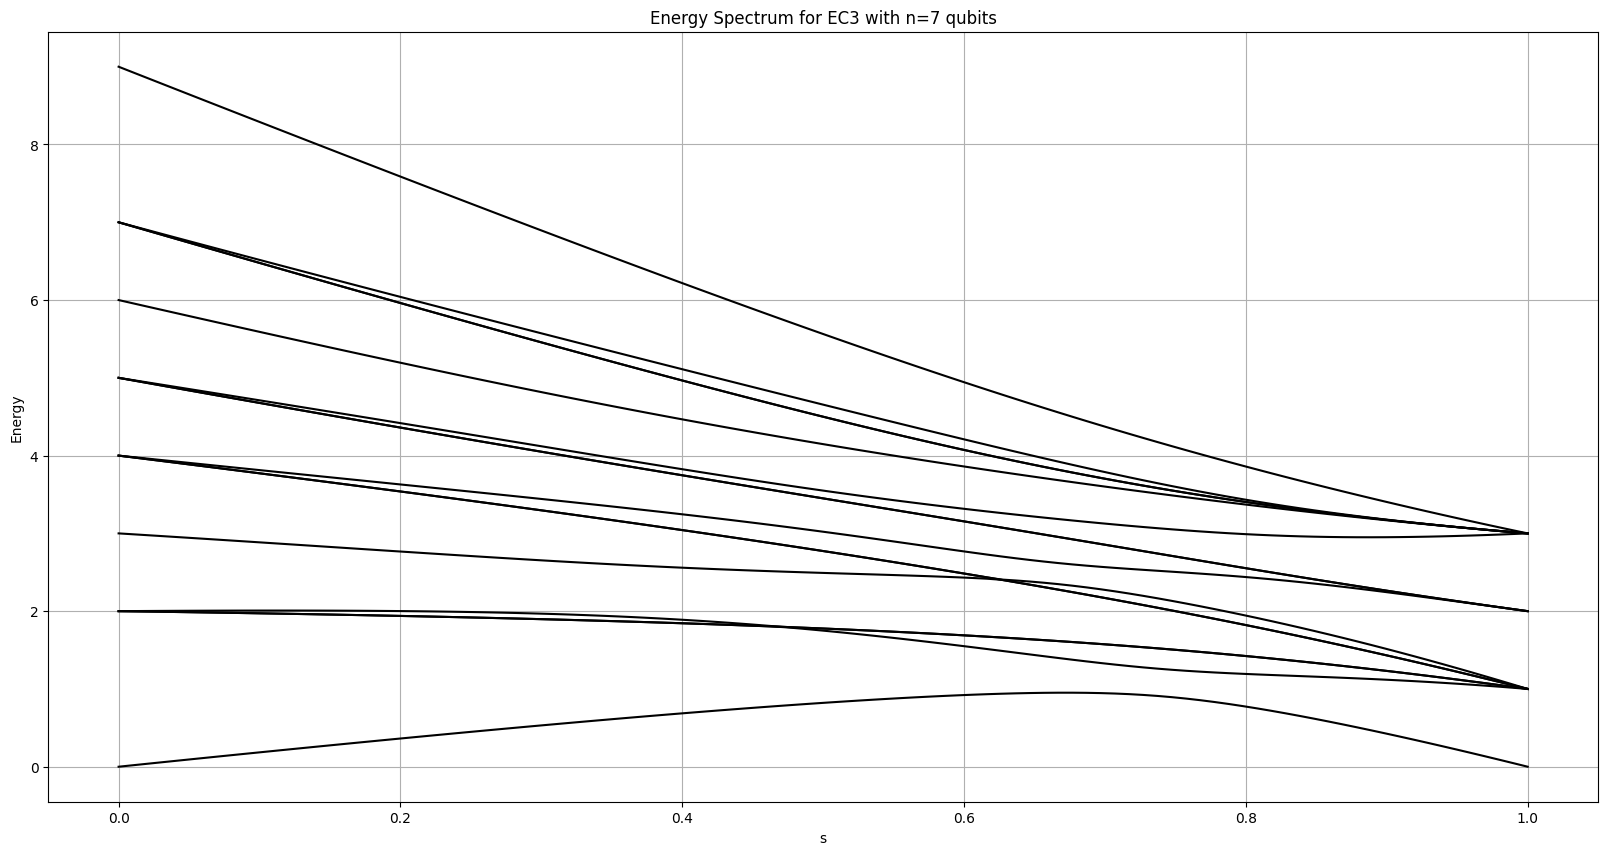

In [432]:
# Number of qubits
n_qubits = 4

unique_solution = generate_random_solution(n_qubits)
clauses = generate_unique_ec3_instance(n_qubits, 3, unique_solution)

print(f"Unique satisfying bitstring: {''.join(map(str, unique_solution))}")
print(f"Generated EC3 clauses (n={n_qubits}):")
for clause in clauses:
    print(clause)
    

# Define single-qubit Pauli-X and Identity matrices
I = qeye(2)
I_7 = tensor([I for _ in range(n_qubits)])
X = sigmax()
Z = sigmaz()

def H_B(clauses):
    H_b = 0
    for (i, j, k) in clauses:
        H_b += 0.5 * (I_7 - tensor([X if x == i else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == j else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == k else I for x in range(n_qubits)]))
    return H_b

def check_clause_violation(state_binary, clause):
    i, j, k = clause
    bits = [state_binary[i], state_binary[j], state_binary[k]]
    return sum(bits) != 1

def cost_function(z, clauses):
    bitstring = f"{z:0{n_qubits}b}"
    bit_values = [int(b) for b in bitstring] 

    violations = 0
    for clause in clauses:
        if check_clause_violation(bit_values, clause):
            violations += 1  # Clause is violated

    return violations

# Problem Hamiltonian H_P
def H_P(clauses):
    H_p = 0
    for z in range(2**n_qubits):
        state = basis(2**n_qubits, z)

        h_z = cost_function(z, clauses)
        projector_z = state * state.dag()
        
        H_p += h_z * projector_z
    return H_p

def H_t(s, Hp, Hb):
    return (1 - s) * Hb + s * Hp

s_values = np.linspace(0, 1, 100)
Hb = H_B(clauses)
Hp = H_P(clauses)
Hb = Qobj(Hb.data, dims=Hp.dims)

energy_diff = None
# Calculate the energy spectrum
energy_spectrum = []
for s in s_values:
    H = H_t(s, Hp, Hb)
    energies = H.eigenenergies()
    energy_spectrum.append(energies)
    
    eg_inst = energies[1] - energies[0]
    if not energy_diff:
        energy_diff = eg_inst
    if energy_diff > eg_inst:
        energy_diff = eg_inst

print("Energy diff is: ", energy_diff)

energy_spectrum = np.array(energy_spectrum)
# Plot the energy spectrum
plt.figure(figsize=(20, 10))
for i in range(2**n_qubits):
    plt.plot(s_values, energy_spectrum[:, i], color='black')

plt.xlabel('s')
plt.ylabel('Energy')
plt.title('Energy Spectrum for EC3 with n=7 qubits')
plt.grid(True)
plt.show()

# Checking if the GS is the unique assignment

In [434]:
eigenvalues, eigenstates = Hp.eigenstates()

ground_state = eigenstates[np.argmin(eigenvalues)]

solution_bitstring_index = np.argmax(np.abs(ground_state.full()))
solution_bitstring = f"{solution_bitstring_index:0{n_qubits}b}"

print(f"Solution bitstring (EC3 solution): {solution_bitstring}")

Solution bitstring (EC3 solution): 0001


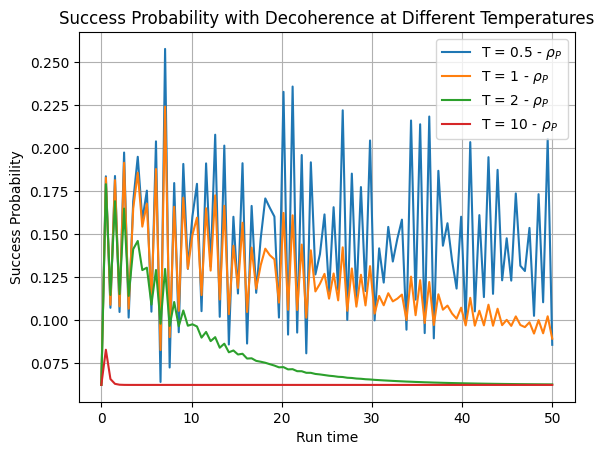

In [446]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / temperature) - 1)

def dissipator(ops, temperature, energy_diff, l):
    decay_rate = bose_einstein_distribution(energy_diff, temperature)
    return decay_rate * (l**2) * (ops.dag() * ops)

times = np.linspace(0, 20, 100)
s_values = times / max(times)

lambda_2 = 0.1

# temperatures = [1/10, 1/2, 1, 2, 10]
temperatures = [1/2, 1, 2, 10]

# Initial state (starting in the ground state of H_B)
eigenvalues, eigenstates = Hb.eigenstates()
ground_state_0 = eigenstates[0]
rho0 = Qobj((ground_state_0 * ground_state_0.dag()), dims=Hp.dims)

# Target state (ground state of H_P)
target_state = Hp.groundstate()[1]
rho1 = target_state * target_state.dag()


# Solve the master equation for each temperature
e_ops = [rho0, rho1]
for T in temperatures:
    c_ops = []
    for i in range(n_qubits):
        sigma_i = tensor([sigmam() if j == i else I for j in range(n_qubits)])
        c_ops.append(Qobj(dissipator(sigma_i, T, energy_diff, np.sqrt(lambda_2)).data, dims=Hp.dims))
    
    results = mesolve([H_t(s, Hp, Hb) for s in s_values], rho0, times, c_ops, e_ops=e_ops)

    # success_prob = [np.abs(state.overlap(target_state)) for state in results.states]
    # plt.plot(times, success_prob, label=f"T = {T}")
    
    # exp1 = results.expect[0]
    exp2 = results.expect[1]
    # plt.plot(times, exp1, label=f"T = {T} - " + r"$\rho_{B}$")
    plt.plot(times, exp2, label=f"T = {T} - " + r"$\rho_{P}$")
    
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability with Decoherence at Different Temperatures')
plt.legend()
plt.grid(True)
plt.show()